# Transfer learning sur Keras

Le but de ce notebook est de faire une implémentation jouet du transfer learning avec keras, qui utilise la base de données des chients de Stanford, avec 120 classes et les poids de InceptionV3 entraîné sur imagenet.

## Importation des packages

In [0]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as k 
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
import tensorflow as tf
from glob import glob
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import matplotlib.image as mpimg

In [0]:
from google.colab import drive

In [52]:
# This will prompt for authorization for the google drive
drive.mount('/content/drive')

# Change directory 
os.chdir('../content/drive/My Drive/Colab Notebooks')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileNotFoundError: ignored

In [53]:
!pwd

/content/drive/My Drive/Colab Notebooks


## Import data

Data from kaggle : https://www.kaggle.com/c/dog-breed-identification/data

In [0]:
# !unzip train.zip
# !unzip test.zip

In [55]:
# Train and test 

train_data_dir = 'train/'
validation_data_dir = 'test/'

# Labels 

data_labels = pd.read_csv('labels.csv')
data_labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


## Check Number of Classes in the Dataset

The dataset contain 120 different dog breeds

In [56]:
v = 1500
target_labels = data_labels['breed']
target_labels = target_labels[0:v]
print(len(set(target_labels)))
print(target_labels.shape)

120
(1500,)


## Prepare labels in one hot encoding

In [57]:
labels_ohe_names = pd.get_dummies(target_labels, sparse=True) # One hot encoding with pandas 
labels_ohe = np.asarray(labels_ohe_names) # transform as array 
print(labels_ohe.shape)
print(labels_ohe[:2])

# Match each image with its label
data_labels['image_path'] = data_labels.apply( lambda row: (train_data_dir + row["id"] + ".jpg" ), axis=1)
data_labels.head()

(1500, 120)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]]


,id,breed,image_path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,train/000bec180eb18c7604dcecc8fe0dba07.jpg
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg
2,001cdf01b096e06d78e9e5112d419397,pekinese,train/001cdf01b096e06d78e9e5112d419397.jpg
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,train/00214f311d5d2247d5dfe4fe24b2303d.jpg
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,train/0021f9ceb3235effd7fcde7f7538ed62.jpg


## Train test split

In [0]:
# Gives the image_path 
tmp = data_labels['image_path'].values.tolist()

# Transform the images as a vectors of numbers
train_data = np.array([img_to_array(
                            load_img(img, 
                                     target_size=(299, 299))
                       ) for img 
                           in tmp[0:v]
                      ]).astype('float32')


In [59]:
x_train, x_test, y_train, y_test = train_test_split(train_data, 
                                                    target_labels, 
                                                    test_size=0.3, 
                                                    stratify=np.array(target_labels), 
                                                    random_state=42)

print("X_train shape:", x_train.shape, "\nFinal X_test shape:", x_test.shape)

x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                    y_train, 
                                                    test_size=0.15, 
                                                    stratify=np.array(y_train), 
                                                    random_state=42)

print("Final X_train shape: ", x_train.shape, "\nFinal X_val shape: ", x_val.shape)

y_train_ohe = pd.get_dummies(y_train.reset_index(drop=True)).as_matrix()
y_val_ohe = pd.get_dummies(y_val.reset_index(drop=True)).as_matrix()
y_test_ohe = pd.get_dummies(y_test.reset_index(drop=True)).as_matrix()

print("Shape y_train:", y_train_ohe.shape, "\nShape y_test: ", y_test_ohe.shape, "\nShape y_val", y_val_ohe.shape)

X_train shape: (1050, 299, 299, 3) 
Final X_test shape: (450, 299, 299, 3)
Final X_train shape:  (892, 299, 299, 3) 
Final X_val shape:  (158, 299, 299, 3)
Shape y_train: (892, 120) 
Shape y_test:  (450, 120) 
Shape y_val (158, 120)


## Model

In [0]:
img_width, img_height = 299, 299

In [61]:
# Use InceptionV3 and remove the last layer 
model = applications.InceptionV3(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
model.summary() # gives the architecture

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_94 (Batc (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_v1_94[0][0]  
__________________________________________________________________________________________________
conv2d_95 

## Define the architecture and the layers customized

In [62]:
y_train_ohe.shape[1]

120

In [63]:
#Adding custom Layers 
out = model.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
total_classes = y_train_ohe.shape[1]
predictions = Dense(total_classes, activation='softmax')(out)
#Now we will be training only the classifiers (FC layers)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_94 (Batc (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_v1_94[0][0]  
__________________________________________________________________________________________________
conv2d_95 

In [0]:
# Set all the weights to be non trainable
# Only want to train the last layers 
for layer in model.layers:
    layer.trainable = False
    
# or if we want to set the first 20 layers of the network to be non-trainable
# for layer in model.layers[:20]:
#     layer.trainable=False

# creating the final model 
model_final = Model(inputs= model.input, outputs=predictions)
    

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = 'Adam', metrics=["accuracy"])


In [0]:
batch_size = 32
epochs = 50

In [0]:
# Create train generator.
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2, 
                                   horizontal_flip = 'true')

train_generator = train_datagen.flow(x_train, y_train_ohe, shuffle=False, batch_size= batch_size, seed=1)



In [0]:
train_steps_per_epoch = x_train.shape[0] // batch_size
val_steps_per_epoch = x_val.shape[0] // batch_size


In [67]:
history = model_final.fit_generator(train_generator,
                                          steps_per_epoch=train_steps_per_epoch,
                                          validation_data= (x_val, y_val_ohe),
                                          validation_steps=val_steps_per_epoch,
                                          epochs= 50,
                                          verbose=1)

Epoch 1/50
28/28 [==============================] - 28s 984ms/step - loss: 4.7645 - acc: 0.0303 - val_loss: 4.3050 - val_acc: 0.2278
Epoch 2/50
28/28 [==============================] - 26s 927ms/step - loss: 3.8712 - acc: 0.2186 - val_loss: 3.1835 - val_acc: 0.3797
Epoch 3/50
28/28 [==============================] - 26s 928ms/step - loss: 2.5139 - acc: 0.4552 - val_loss: 2.1077 - val_acc: 0.5190
Epoch 4/50
28/28 [==============================] - 26s 923ms/step - loss: 1.6000 - acc: 0.5975 - val_loss: 1.7631 - val_acc: 0.5127
Epoch 5/50
28/28 [==============================] - 26s 918ms/step - loss: 1.1668 - acc: 0.6839 - val_loss: 1.4510 - val_acc: 0.6519
Epoch 6/50
28/28 [==============================] - 26s 927ms/step - loss: 0.9311 - acc: 0.7444 - val_loss: 1.4963 - val_acc: 0.6392
Epoch 7/50
28/28 [==============================] - 26s 916ms/step - loss: 0.7386 - acc: 0.7971 - val_loss: 1.3928 - val_acc: 0.6646
Epoch 8/50
28/28 [==============================] - 26s 925ms/step - 

In [0]:
# Save the model 
model_final.save('dog_transfer_learning.hdf5')

## Visualize model performance

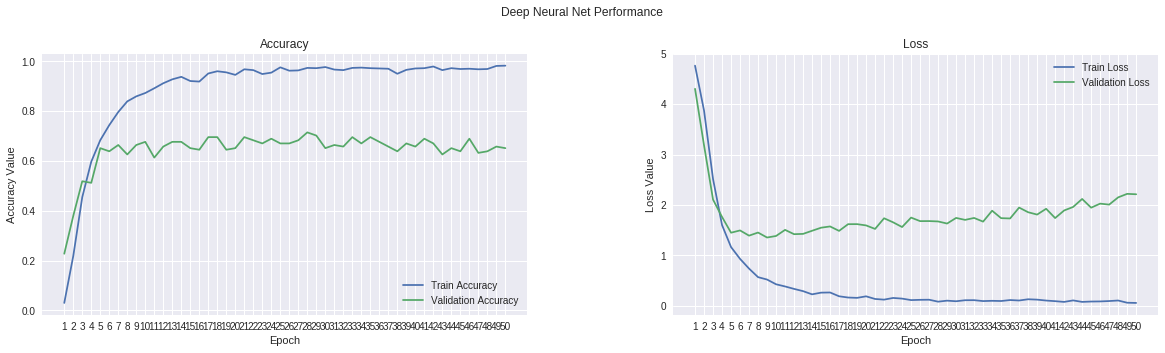

In [76]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,51))
ax1.plot(epochs, history.history['acc'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Performance

In [77]:
test_predictions = model_final.predict(x_test)
predictions = pd.DataFrame(test_predictions, columns=labels_ohe_names.columns)
test_labels = list(y_test)
predictions = list(predictions.idxmax(axis=1))
predictions[:10]

['tibetan_terrier',
 'pomeranian',
 'german_short-haired_pointer',
 'affenpinscher',
 'malamute',
 'basset',
 'bluetick',
 'shetland_sheepdog',
 'maltese_dog',
 'blenheim_spaniel']

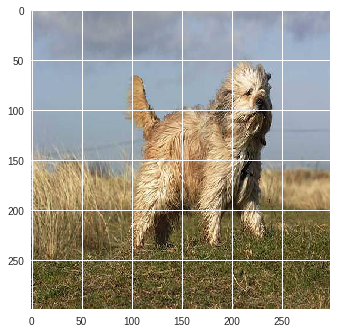

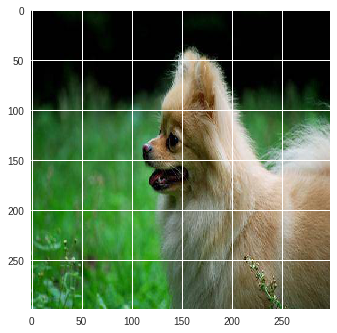

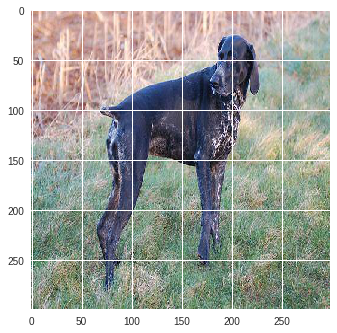

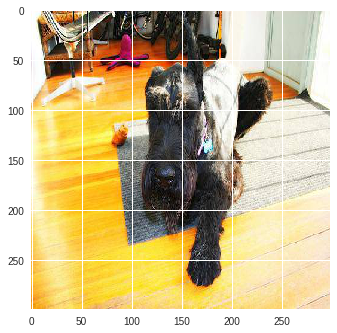

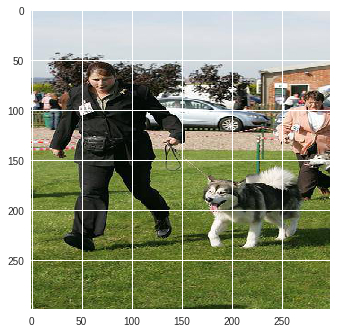

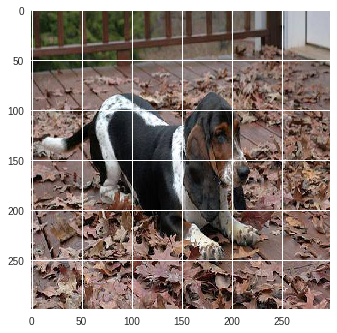

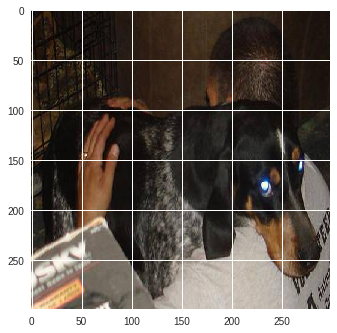

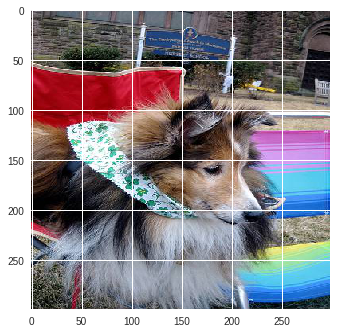

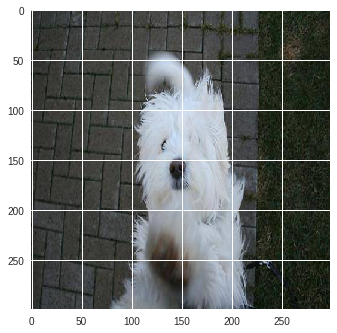

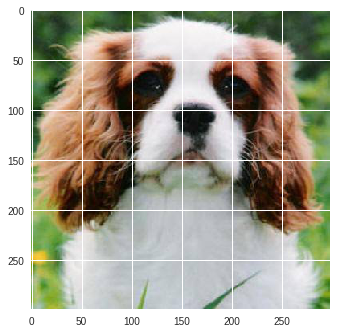

In [121]:
for i in range(10):
    imgplot = plt.imshow((x_test[i]).astype(np.uint8))
    plt.show()

In [101]:
from google.colab import files
src = list(files.upload().values())[0]
open('model_evaluation_utils.py','wb').write(src)

Saving model_evaluation_utils.py to model_evaluation_utils (1).py


8575

In [102]:
import model_evaluation_utils as meu

meu.get_metrics(true_labels=test_labels, 
                predicted_labels=predictions)

Accuracy: 0.6711
Precision: 0.728
Recall: 0.6711
F1 Score: 0.6599


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
